In [1]:
import torch
import numpy as np
from torch import optim
import os
import matplotlib.pyplot as plt
import seaborn

In [2]:
#from datareader import DLEMDataset
#from models.encodetocontact_forked import DLEM
#import util
import dlem.util as util
from dlem import load_reader, load_model

In [3]:
import dlem

In [4]:
def return_pred_diag(model, patchs, tracks):
    patchs = torch.from_numpy(patchs)
    tracks = torch.from_numpy(tracks)
    init_diag = torch.from_numpy(np.ones((tracks.shape[0], tracks.shape[2]), dtype=np.float32))
    return model.contact_map_prediction(tracks, init_diag)

In [5]:
def return_pred_param(model, patch, tracks):
    patch = torch.from_numpy(patch)
    tracks = torch.from_numpy(tracks)
    init_diag = torch.from_numpy(np.ones((tracks.shape[0], tracks.shape[2]), dtype=np.float32))
    def convert_diags(diags):
        return util.convert_diags_to_full_contact(
                    diags,
                    model.start_diag,
                    model.stop_diag
               )

    preds = model.contact_map_prediction(tracks, init_diag)
    preds = [convert_diags(p) for p in preds]

    p_l, p_r = model.return_parameters(tracks)
    return preds, p_l, p_r


In [6]:
!ls ../.data/dlem_training

2_per_route	       5_per_route	features.dat   trained_forked_model
3_per_route_diffusion  contactmaps.dat	meta.json      trained_forked_model_1
4_per_route	       deneme		sequences.bed  trained_models


In [7]:
BATCH_SIZE = 64
#DATA_FOLDER = ".data/dlem_training"
DATA_FOLDER = "../loopextrusion_data_creation/.data/training_data_res_1000_patch_size_500"
DATA_FOLDER = "../.data/dlem_training"
TEST_FOLD = 'fold4'
VAL_FOLD = 'fold5'
LEARNING_RATE = 0.001
PATIENCE = 200
NUM_EPOCH = 100
NUMBER_OF_CHANNELS_PER_ROUTE = 3
MODEL_FOLDER = f"{NUMBER_OF_CHANNELS_PER_ROUTE}_per_route_res_1000"

In [8]:
dev = torch.device("cpu")

In [9]:
data = load_reader("datareader")(DATA_FOLDER)

data_test = torch.utils.data.Subset(data, np.where(data.data_folds == TEST_FOLD)[0])

In [10]:
data.stop_diag

80

In [11]:
model =load_model("encodetocontact_forked")(data.patch_dim,
             data.feature_dim,
             data.start_diag,
             data.stop_diag,
             channel_per_route=NUMBER_OF_CHANNELS_PER_ROUTE)

In [12]:

model.load_state_dict(
         torch.load(os.path.join(DATA_FOLDER, MODEL_FOLDER, "best_correlation.pt"))
)
model = model.to(dev).eval()

FileNotFoundError: [Errno 2] No such file or directory: '../.data/dlem_training/3_per_route_res_1000/best_correlation.pt'

In [13]:
model.load_state_dict(
         torch.load(os.path.join(DATA_FOLDER, "trained_forked_model", "best_correlation.pt"))
)
model = model.to(dev).eval()

In [14]:
model

DLEM(
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv1d(4, 12, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(9, 9, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv1d(6, 6, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (3): Sequential(
      (0): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
  )
  (trans_convs): ModuleList(
    (0-3): 4 x Sequential(
      (0): ConvTranspose1d(3, 3, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
  )
  (mixer): Sequential(
    (0): Conv1d(12, 2, kernel_size=(1,), stride=(1,))
    (1): Sigmoid()
  )
)

In [15]:
def plot_one_sample(patch, pred, p_l, p_r, scale, axes):
    util.plot_results(patch, pred,
                (p_l, p_r, np.ones_like(p_l)),
                ignore_i=data.start_diag, ignore_i_off=data.stop_diag,
                cmap="vlag", scale=scale, axes=axes)

def plot_multiple_samples(nrows, ncols, samples, model, scale=0.4):
    preds, p_l, p_r = return_pred_param(model, samples[0], samples[1])
    patch_mat = [util.convert_diags_to_full_contact(patch, model.start_diag, model.stop_diag) for patch in samples[0]]
    _, axes = plt.subplots(nrows=2*nrows, ncols=2*ncols, figsize=(ncols*12*scale, nrows*12*scale),
                                sharex='col',
                                sharey='row',
                                gridspec_kw={'wspace':0,
                                            'hspace':0,
                                            'height_ratios':[1, 5] * nrows,
                                            'width_ratios':[5, 1] * ncols})
    i = 0
    for r in range(nrows):
        for c in range(ncols):
            plot_one_sample(patch_mat[i], preds[i], p_l[i], p_r[i], scale, axes[2*r:2*(r+1), 2*c:2*(c+1)])
            i += 1

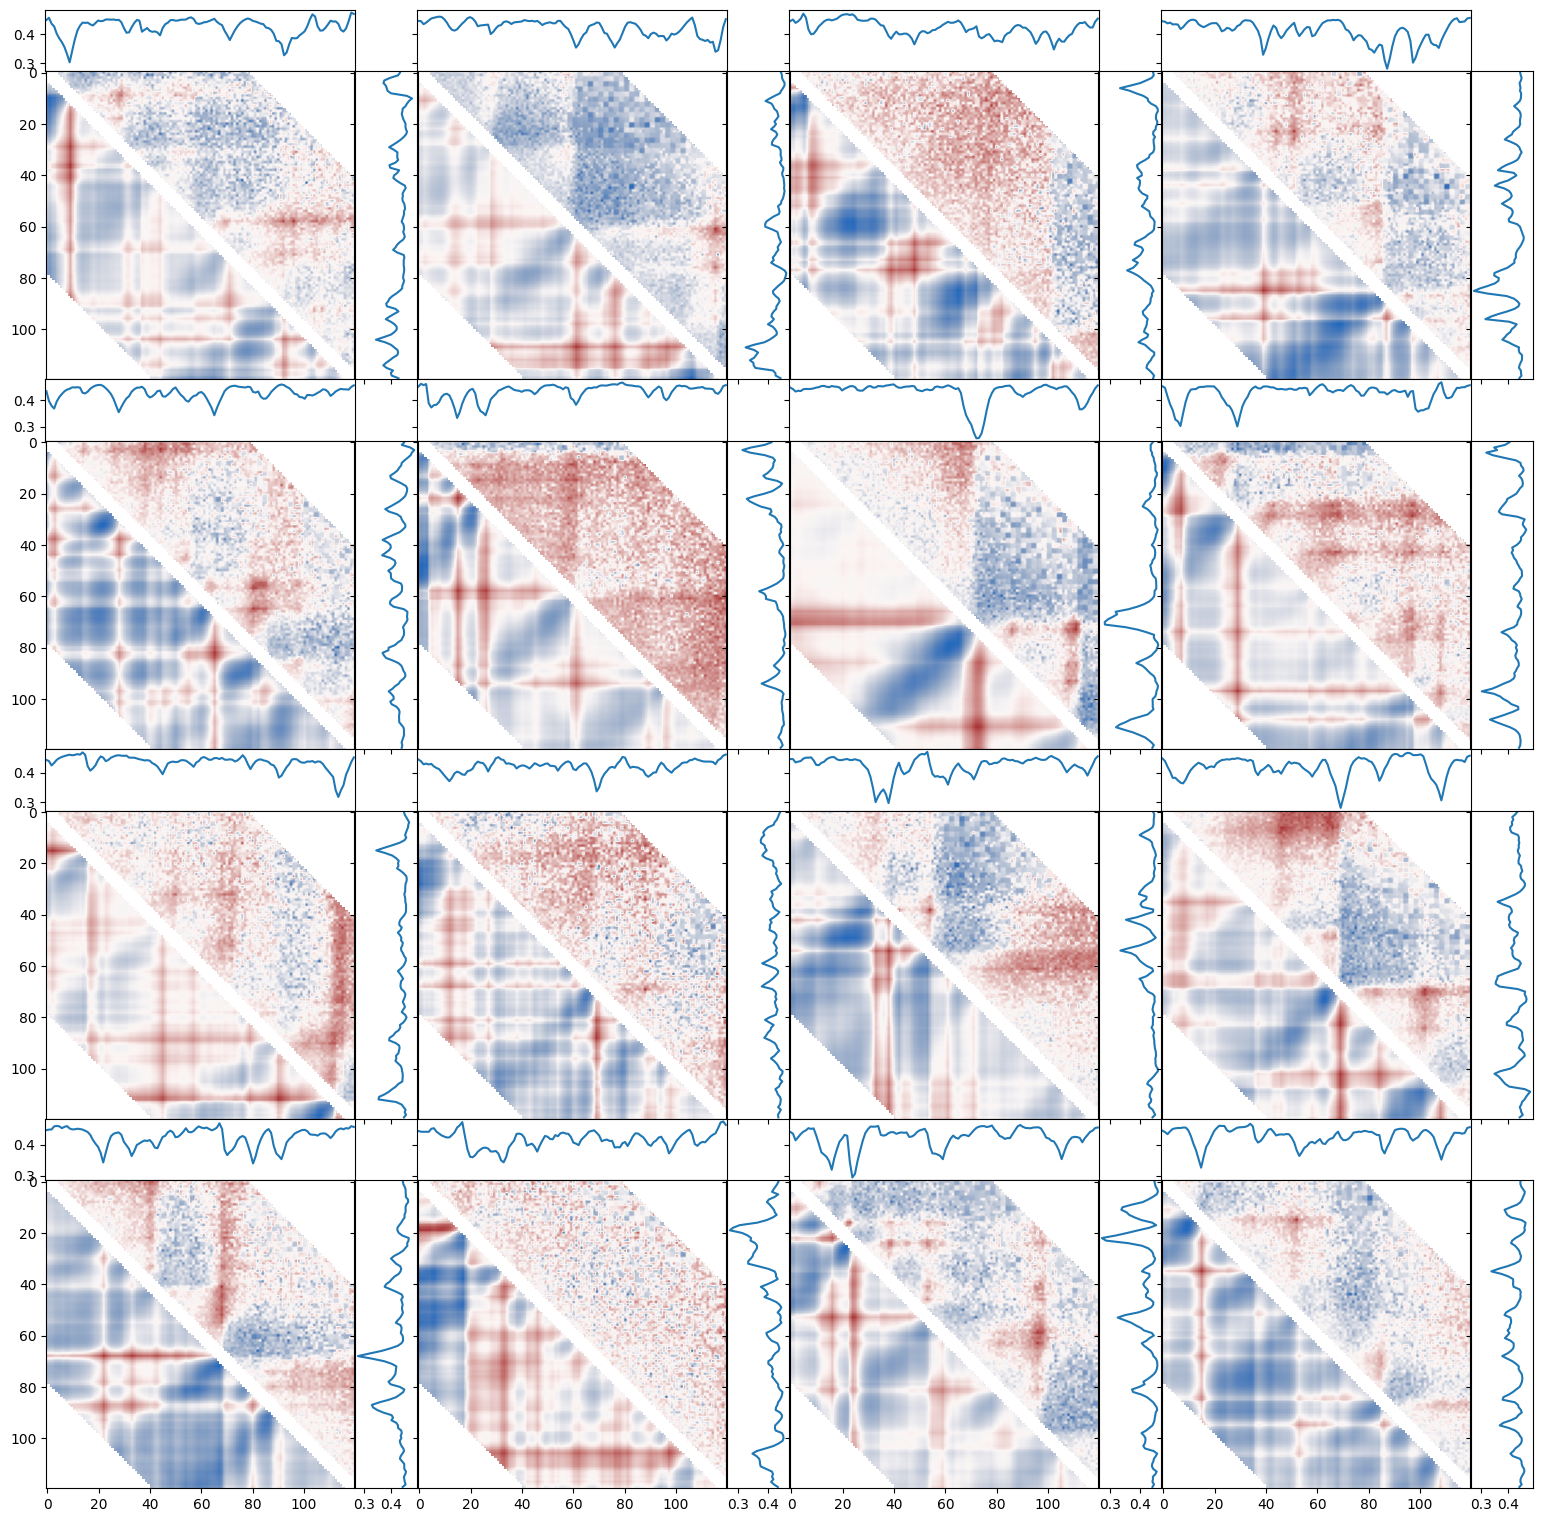

In [16]:
plot_multiple_samples(4,4,data_test[np.random.choice(range(len(data_test)), 16)], model)

Cherry picking

In [17]:
corrs = []
for i in range(len(data_test)//10):
    pred = return_pred_diag(model, data_test[i*10:(i+1)*10][0], data_test[i*10:(i+1)*10][1])
    corrs.append(np.diag(np.corrcoef(data_test[i*10:(i+1)*10][0],pred.detach().cpu().numpy())[:10,10:]))

In [18]:
corrs = np.concatenate(corrs)

In [19]:
np.max(corrs)

0.7936134757956125

In [20]:
np.mean(corrs)

0.41854375562679946

In [21]:
np.median(corrs)

0.44633978011255315

Text(0.5, 14.722222222222216, 'Correlation')

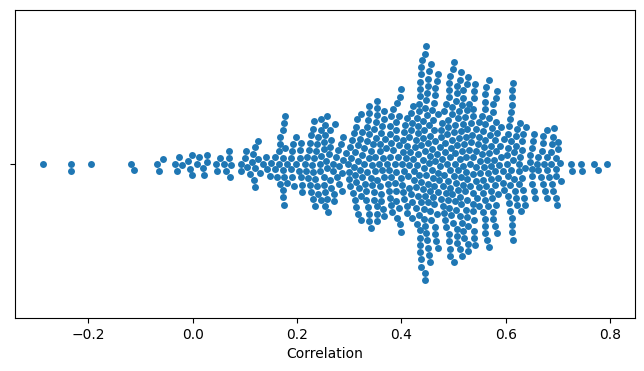

In [22]:
plt.figure(figsize=(8,4))
seaborn.swarmplot(x=corrs)
plt.xlabel("Correlation")

<Axes: >

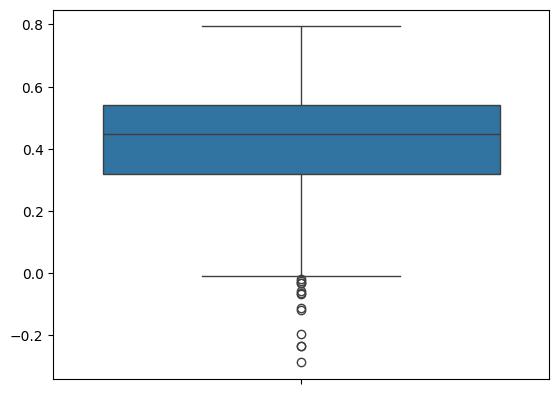

In [23]:
seaborn.boxplot(corrs)

In [24]:
np.quantile(corrs, 0.01)

-0.06540221266185547

In [25]:
np.sort(corrs[0>corrs])

array([-0.28683485, -0.23380565, -0.23289453, -0.19504743, -0.11890996,
       -0.11214005, -0.06748076, -0.06484969, -0.05762582, -0.03297301,
       -0.03090805, -0.02641434, -0.01986569, -0.00826928, -0.00531679,
       -0.00125462, -0.00085394])

In [26]:
corrs[np.argsort(-corrs)[:16]]

array([0.79361348, 0.7767072 , 0.76900241, 0.74581572, 0.74425567,
       0.7269612 , 0.72568949, 0.70641098, 0.7046866 , 0.70075023,
       0.69995486, 0.6982922 , 0.69732669, 0.69667942, 0.6963913 ,
       0.69574154])

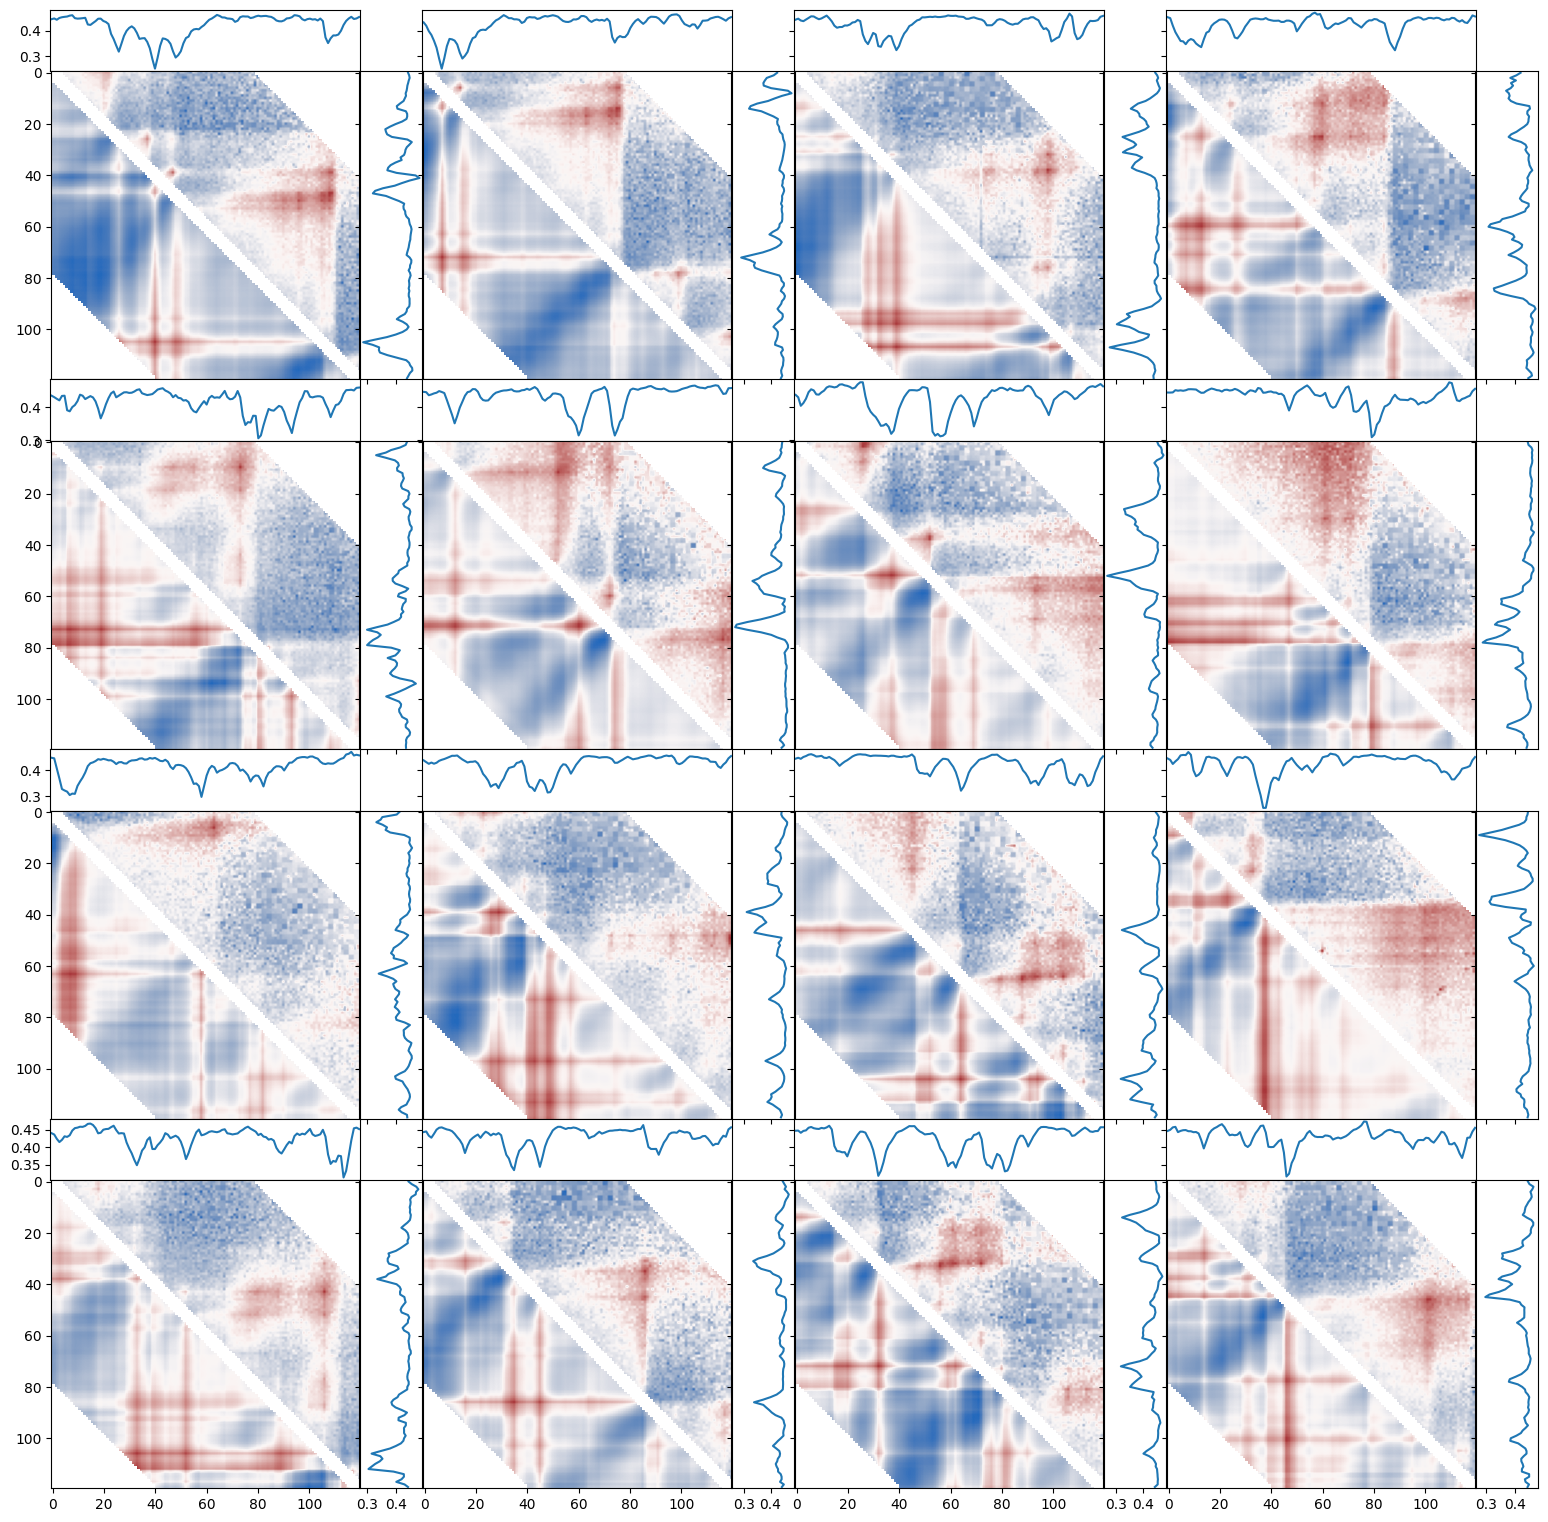

In [27]:
plot_multiple_samples(4,4,data_test[np.argsort(-corrs)[:16]], model)

In [28]:
corrs[np.argsort(corrs)[:16]]

array([-0.28683485, -0.23380565, -0.23289453, -0.19504743, -0.11890996,
       -0.11214005, -0.06748076, -0.06484969, -0.05762582, -0.03297301,
       -0.03090805, -0.02641434, -0.01986569, -0.00826928, -0.00531679,
       -0.00125462])

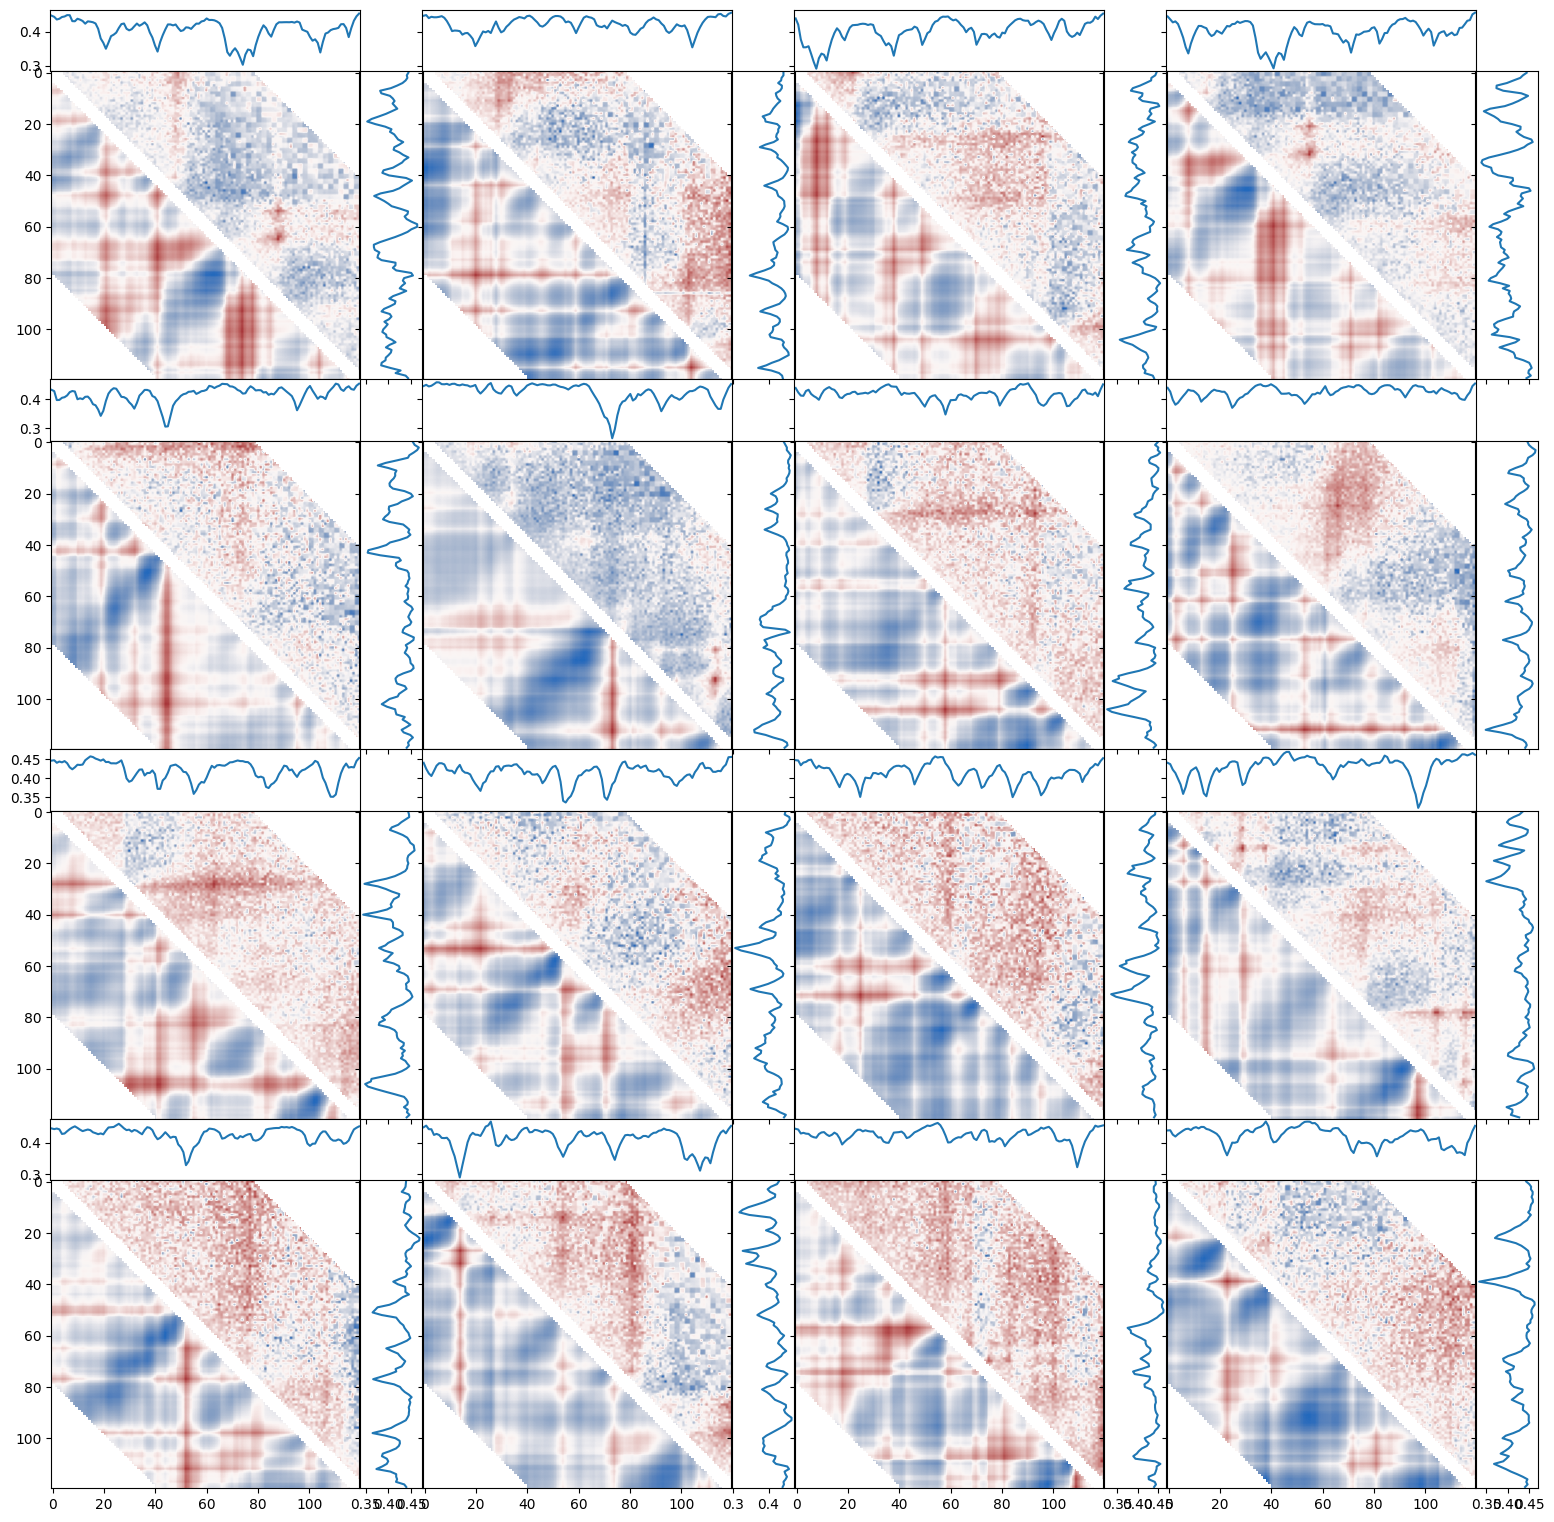

In [29]:
plot_multiple_samples(4,4,data_test[np.argsort(corrs)[:16]], model)

In [30]:
samples = data_test[[np.argsort(-corrs)[3]]]
preds, p_l, p_r = return_pred_param(model, samples[0], samples[1])
patch_mat = [util.convert_diags_to_full_contact(patch, model.start_diag, model.stop_diag) for patch in samples[0]]

In [34]:
!pwd

/data/src/loopextrusion_pytorch/dlem/examples


In [39]:
np.save("data/patch_deep.npy", patch_mat[0])
np.save("data/encode_deep.npy", data_test[[np.argsort(-corrs)[3]][0]][1])

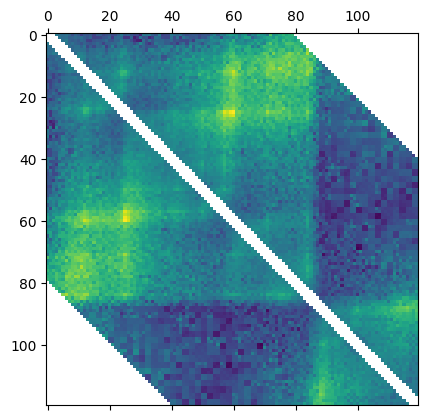

In [33]:
plt.matshow(patch_mat[0])

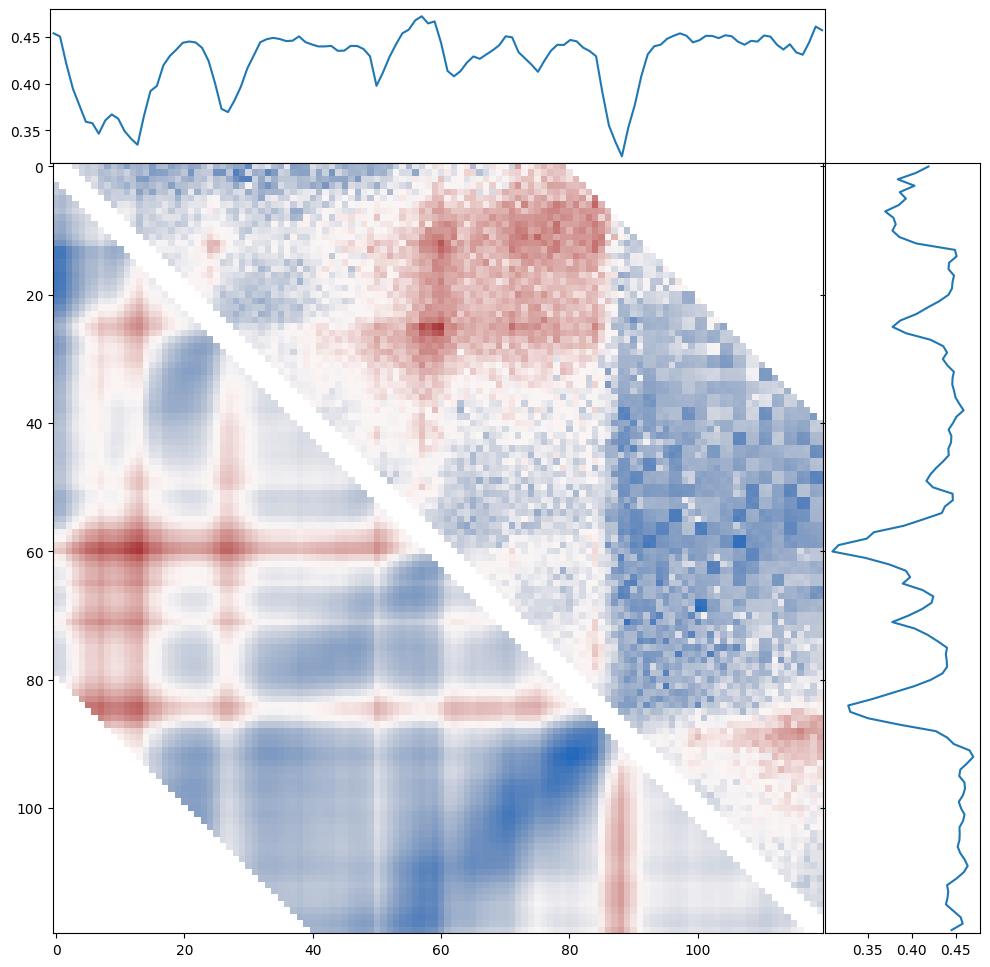

In [31]:
util.plot_results(patch_mat[0], preds[0],
                (p_l[0], p_r[0], np.ones_like(p_l)),
                ignore_i=data.start_diag, ignore_i_off=data.stop_diag,
                cmap="vlag", scale=1)

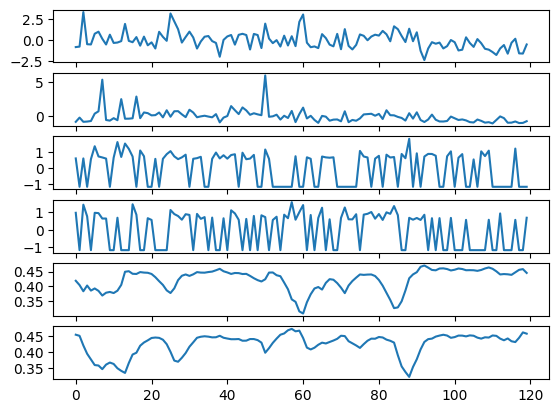

In [ ]:
fig, axes = plt.subplots(nrows=6)
for i, ax in enumerate(axes[:samples[1].shape[1]]):
    ax.plot(samples[1][0, i])
axes[4].plot(p_l[0])
axes[5].plot(p_r[0])

In [ ]:
tick_labels = np.array(["CTCF", "DNAse", "CTCF(left)", "CTCF(right)", "left", "right"])

In [ ]:
corrs_params = np.corrcoef(np.vstack([samples[1][0], p_l, p_r]))

In [ ]:
corrs_params.shape

(6, 6)

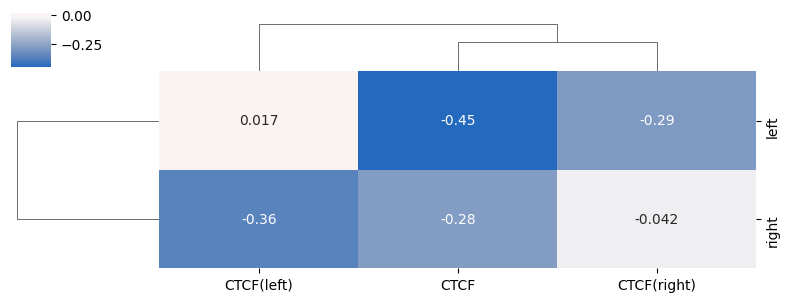

In [ ]:
seaborn.clustermap(corrs_params[[4, 5]][:,[0, 2, 3]],
                   yticklabels=tick_labels[[4,5]],
                   xticklabels=tick_labels[[0,2,3]],
                   cmap="vlag",
                   center=0,
                   annot=True,
                   figsize=(8,3))

In [ ]:
np.corrcoef(np.random.rand(3, 4, 100))

ValueError: m has more than 2 dimensions

In [ ]:
samples[1]

array([[[-8.0528766e-01, -7.4868065e-01,  3.3235834e+00, -4.6815285e-01,
         -4.9707738e-01,  7.6909184e-01,  1.0109735e+00,  1.7318845e-01,
         -5.0089842e-01,  6.5615392e-01, -3.1700006e-01, -2.6933208e-01,
         -1.0096393e-01,  1.9295934e+00, -7.4461378e-02, -2.3091686e-01,
          3.7341231e-01, -6.3687319e-01,  4.2821354e-01, -5.9511632e-01,
         -2.5096005e-01, -9.7183365e-01,  9.9654466e-01,  3.9828581e-01,
         -6.7068890e-02,  3.1595831e+00,  2.2265038e+00,  1.3056930e+00,
         -2.7391520e-01,  3.8700494e-01,  1.0160426e+00,  3.3133548e-01,
         -9.7765398e-01, -1.4446107e-01,  4.1861504e-01,  4.9795440e-01,
         -1.0057809e-01, -3.1586298e-01, -1.9454298e+00,  4.2047568e-02,
          4.5075962e-01,  6.2009495e-01, -5.1696712e-01,  6.4165986e-01,
          7.6093173e-01,  6.1840940e-01, -1.0906390e+00,  7.4535424e-01,
          6.1676472e-01, -9.2125893e-01,  1.9633474e+00,  2.0141661e-01,
         -3.4049568e-01,  1.3084199e-02, -7.4045318